## Metaverse Transaction Data Analysis
 
### Anomaly classification (low_risk, medium_risk, high_risk) with meta transaction data

In [1]:
### Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle
import os

### Other Options
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'


In [2]:
import pickle
import os
# Set working directory
os.chdir('C:/Users/WulfN') 

# Read in modeling dataframe
meta_model_df = pd.read_pickle('./Python Projects/Meta-Transaction-Risk-Classification/meta_model_df.pkl')

### Split modeling dataframe into training and validation set
- Creating function to generate downsampled training dataset
    - Validation set is not downsampled to ensure mode is robust on 'real-world' dataset
- Enter target variable to determine the training / validation data split
    - **target_variable = 'anomaly'**; multi-class, with equal representation across *low_risk*, *moderate_risk*, and *high_risk* classes.
    - **target_variable = 'binary_anomaly'**: binary, with equal representation across *low_moderate_risk* and *high_risk* classes
- Subsequent models will either be multi-class or binary classification models. 
- We are interested in assuring the model correctly classifies *high_risk* transactions
    - May then select either multi-class or binary classification model based on what classifies high_risk best


In [3]:
# train / test split with class imbalance using downsampling
import pandas as pd
from sklearn.model_selection import train_test_split

def class_imbalance_train_test_split(data, target_variable, testset_size):
       
       # Training Set and validation set
       df_x = data.drop(columns = ['anomaly', 'anomaly_binary'])
       df_y = data[target_variable] # as category?
       
       ### Train / Test split. Stratify by underrepresented class
       x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = testset_size, stratify = df_y, random_state = 152)

       # Recombine Training sets to downsample
       training_sets = pd.concat([x_train, y_train], axis = 1)
       min_class_size = training_sets[target_variable].value_counts().min() # underepresented class (high risk) count
       print('Class Imbalance')
       print(training_sets[target_variable].value_counts())

       # Downsample training set to resolve problems with imbalanced data
       downsampled_train = (training_sets.groupby(target_variable, group_keys = False)
                            .apply(lambda x: 
                                   x.sample(n = min_class_size, random_state = 44, replace = True))
                            # Reshuffle 
                            .sample(frac = 1, random_state = 42))

       # Override training sets with downsampled versions
       x_train = downsampled_train.drop(columns = target_variable)
       y_train = downsampled_train[target_variable]

       print("\n")
       print('Training Set Class Balance')
       print(y_train.value_counts())

       print("\n")
       print('Validation Set Class Balance ')
       print(y_test.value_counts())
       
       return x_train, x_test, y_train, y_test


In [4]:
# Setting param for following methods that are dependent on the target variable
target_variable = 'anomaly_binary'

objective = 'binary' if target_variable == 'anomaly_binary' else 'multiclass'

# 'anomaly' or 'anomaly_binary' as input
x_train, x_test, y_train, y_test = class_imbalance_train_test_split(data = meta_model_df, target_variable = target_variable, testset_size = .25)

Class Imbalance
anomaly_binary
0    54079
1     4871
Name: count, dtype: int64


Training Set Class Balance
anomaly_binary
1    4871
0    4871
Name: count, dtype: int64


Validation Set Class Balance 
anomaly_binary
0    18026
1     1624
Name: count, dtype: int64


- There exists a target class imbalance (47621 + 6458) to 4871
  - **Multiclass:** (*low_risk*: 47621, *moderate_risk*: 6458, *high_risk*: 4871)
  - **Binary:** (*low_moderate_risk*: 54079, *high_risk*: 4871)
  - Downsampling so that model accuracy is based on correctly identifying high risk transactions
- Retaining class imbalance on validation set to ensure model is accurate on 'real-world' datasets


## Halving Grid Search and Bayesian Optimization
* Hyperparameter Selection
* Compare Accuracy for multiclass and binary classification, and Runtime

### Halving Grid Search
- Using LightGBM
    - Model arguably superior to xgboost that performs well on diverse problems
    - Numerous parameters to lessen training time, and increase accuracy

In [5]:
# halving grid search for light gbm
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# objective can be 'binary' or 'multiclass'

def halving_lightgbm_train(objective, x_train, y_train): 
   # HalvingGridSearch with Light GBM
   classifier = LGBMClassifier()
   
   param_grid = {'objective': [objective], 
               'learning_rate': [.05, .1, .2, .25, .4, .55, .75, 2], 
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
               'feature_fraction': [.01, .1, .2, .3, .4, .5],
               'subsample': [.01, .1, .2, .3, .4, .5],
               'num_leaves': [2**4, 2**5, 2**6, 2**7], 
               'verbosity': [-1],
               'force_col_wise': [True]
               }


   # HalvingGridSearchCV
   halving_grid_search = (HalvingGridSearchCV(classifier, param_grid, cv = 2, random_state = 41, n_jobs = -1) 
                     .fit(x_train, y_train)); 

   # print(f"Best parameters for {classifier}:\n{halving_grid_search.best_params_}")
   # print(f"Best score: {halving_grid_search.best_score_:.4f}\n")

   return halving_grid_search


In [6]:
%%capture 
# Objective is defined globally ('binary' or 'multiclass')
halving_grid_search = halving_lightgbm_train(objective, x_train, y_train)
halving_grid_search

Thoughts:
- HalvingGridSearchCV is difficult to implement with many Light GBM Params, such as boosting_type, early_stopping_round, or different training metrics.
- Requires an explicit grid search.
    - Constrains model to selected hyperparameter values
    - This may prevent model from reaching global optimum
- Resource efficient
    - Full set of hyperarameters in model grid are not tested
    - Prioritizes hyperparameters that improve accuracy

### Halving Grid Search Results on Validation Set

In [7]:
# Create feature importance plot given model predictions for light GBM model
def LGBM_feature_importance(model_output, x_test, y_test):

    # Feature Importance Plot
    opt_model = LGBMClassifier(**model_output.best_params_).fit(x_test, y_test)

    feature_importance = opt_model.feature_importances_
    feature_names = x_test.columns.to_list()

    importances_df = pd.DataFrame({"feature_names" : feature_names, 
                                "importances" : feature_importance})

    feature_importance_plot = sb.barplot(data = importances_df,
                                        x = feature_importance,
                                        y = feature_names,
                                        order = importances_df.sort_values('importances', ascending = False).feature_names)

    plt.title('Feature Importance Plot on Training Set')
    
    return feature_importance_plot

<Axes: title={'center': 'Feature Importance Plot on Training Set'}>

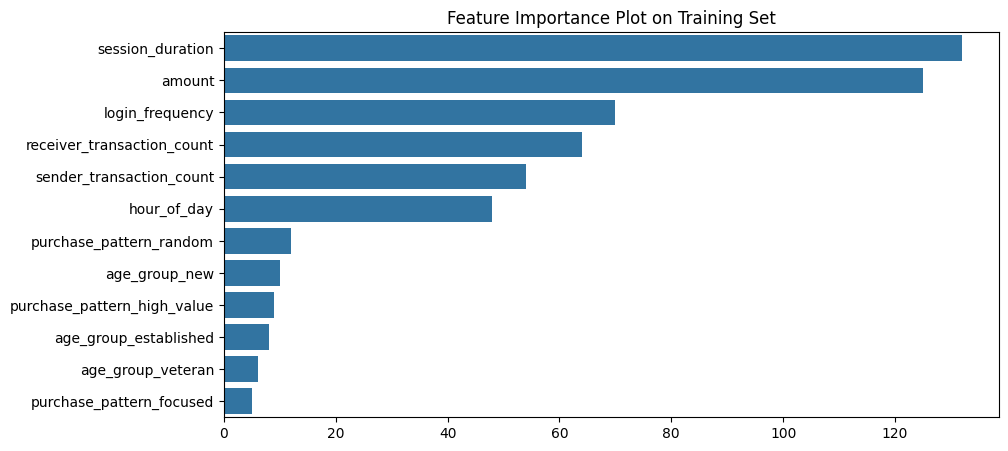

In [8]:
LGBM_feature_importance(halving_grid_search, x_test, y_test)

- engineered features (sender_transaction_count, receiver_transaction_count) explain a large amount of variation in the model
- indicator variables explain a small amount of variation on the model

In [9]:
# Confusion Matrix Dependent on binary or multi-class output

from sklearn.metrics import confusion_matrix, classification_report

def meta_confusion_matrix(y_pred, y_test, objective): # Objective is 'binary' or 'multiclass'
    # Report and Confusion Matrix
    print(classification_report(y_test, y_pred))

    print('\n')

    if objective == 'binary': # Objective is define globally ('binary' or 'multiclass')
        class_labels = [0, 1]   

    else:    
        class_labels = ['low_risk', 'moderate_risk', 'high_risk']
    
    cm = confusion_matrix(y_test, y_pred, labels = class_labels) # Are these labels in the right order? 

    sb.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show(); 

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





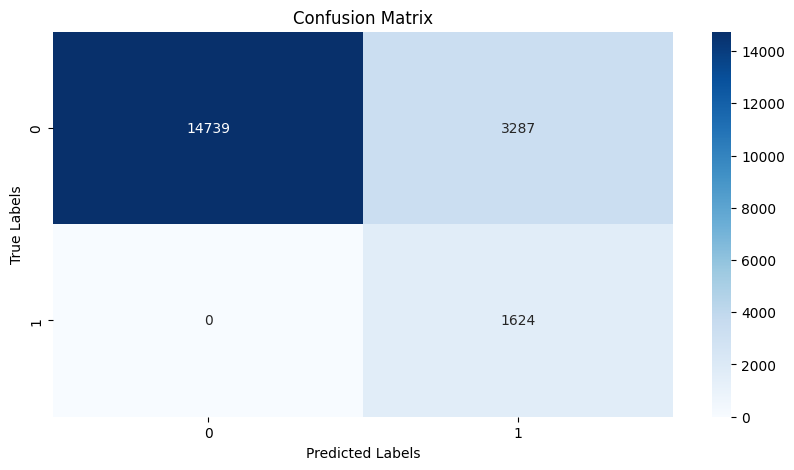

In [10]:
# Predicted values from optimized model 
y_pred = halving_grid_search.best_estimator_.predict(x_test)

meta_confusion_matrix(y_pred, y_test, objective)

### Validation Set Results
- Opting to create binary low-moderate risk (0) and high risk (1) target variable
  - multiclass target variable model performance
    - Accuracy: .79
    - Precision for moderate_risk: .7
    - Precision for high_risk: .33
    - Bonus of classifying moderate_risk transactions reasonably well, if important.
    - *Misclassified (2 + 6) = 8 high_risk transactions*
    
  - binary target variable model performance
    - Accuracy: .83
    - Precision for high_risk: .33
    - 3287 false positives
    - *Correctly identified ALL high-risk transactions*

- **Binary Model narrowly more effective at targeting high-risk transactions**
    - 33% of observations classified as high risk ARE high risk
      - Compared to 8.3% of observations in the validation set being high-risk
    - *Model identifies all high-risk transactions*


### Bayesian Optimization

In [13]:
### BayesSearchCV for Lightgbm model

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

def bayesian_lightgbm_train(objective, x_train, y_train): # 'binary' or 'multiclass'
    # Model Classifier
    classifier = LGBMClassifier()
    
    # Parameter Space
    param_space = {
    'objective': [objective],
    'learning_rate': Real(0.01, 1, prior = 'uniform'),
    'num_leaves': Integer(10, 50),
    'max_depth': Integer(3, 10),
    'boosting_type': Categorical(['gbdt', 'dart']),
    'feature_fraction': Real(0.1, 1, prior = 'uniform'),
    'subsample': Real(0.1, 1, prior = 'uniform'),
    'verbosity': [-1],
    'force_col_wise': [True]
    }

    # Bayesian Optimization with Cross Validation
    light_gbm_bayes_cv = BayesSearchCV(
        estimator = LGBMClassifier(),
        search_spaces = param_space,
        scoring = 'accuracy', 
        cv = 5,
        n_iter = 50, 
        n_jobs = -1,
        return_train_score = True,
        random_state = 42 
    ).fit(x_train, y_train); 

    # print('\n')
    # print(f"Best parameters for {classifier}:\n{light_gbm_bayes_cv.best_params_}")
    # print("Best Score:", light_gbm_bayes_cv.best_score_)
    
    return light_gbm_bayes_cv

In [14]:
%%capture 
bayes_opt_lightgbm = bayesian_lightgbm_train(objective, x_train, y_train)
bayes_opt_lightgbm

### Bayesian Optimization Results

<Axes: title={'center': 'Feature Importance Plot on Training Set'}>

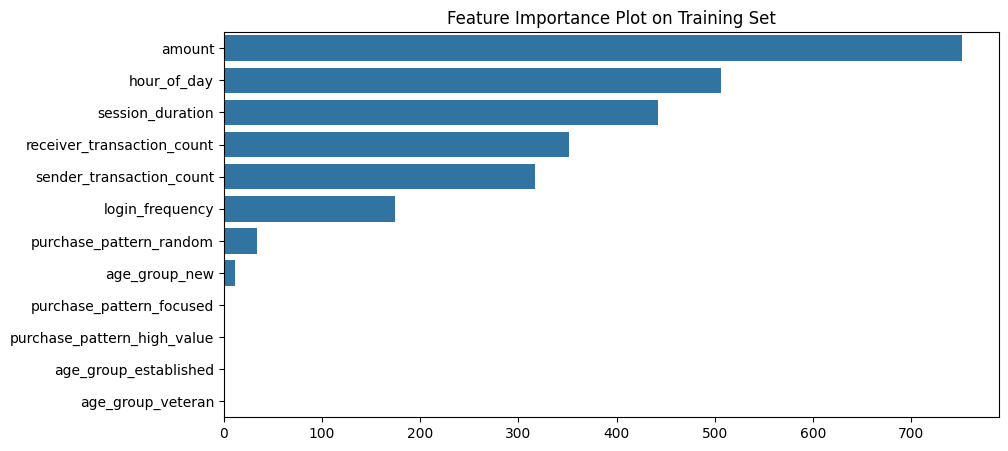

In [29]:
LGBM_feature_importance(bayes_opt_lightgbm, x_test, y_test)

- Same variables as halving grid search explain majority of variation in model, but ordered differently.
- Less importance is given to indicator variables

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      0.99      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





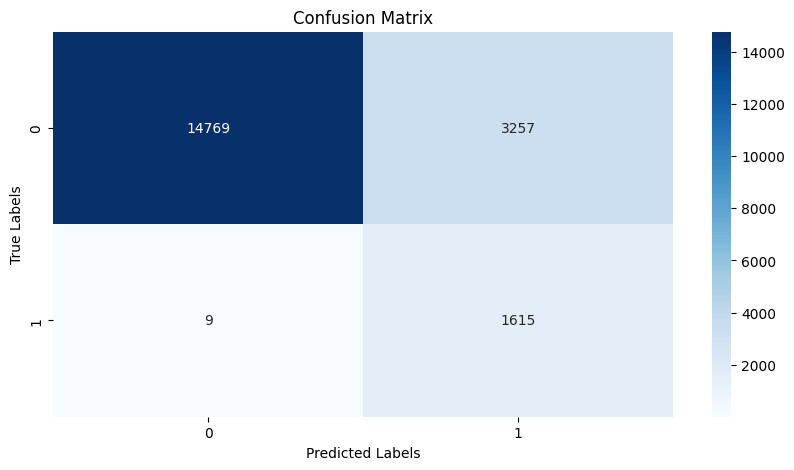

In [30]:
# Set y_pred from bayes search cv results
y_pred = bayes_opt_lightgbm.best_estimator_.predict(x_test)

#'binary' or 'multiclass'
meta_confusion_matrix(y_pred, y_test, objective)

## Validation Set Results
- Opting to create binary low-moderate risk (0) and high risk (1) target variable
  - multiclass target variable model performance
    - Accuracy: .79
    - Precision for moderate_risk: .69
    - Precision for high_risk: .33
    - Bonus of classifying moderate_risk transactions reasonably well, if important.
    - *Misclassified (17 + 35) = 52 high_risk transactions*
    
  - binary target variable model performance
    - Accuracy: .83
    - Precision for high_risk: .33
    - 3257 false positives (30 less than halving grid search)
    - *Misclassified 9 high-risk transactions*

- Similarly, the binary model is marginally better at identifying high-risk transactions.



## Halving Grid Search vs. Bayesian Optimization Comparison
**Which gave a better model for detecting high-risk transactions?**
- Importantly, this is far from an apples to apples comparison
- **multi-class:** HalvingGridSearch 
- **binary:** HalvingGridSearch
- **runtime:** Bayesian Optimization
    - HalvingGridSearch runtime: 4m 43s
    - Bayesian optimization runtime: 2m 10s
        - Bayesian Optimization gave nearly identical results with less than 1/2 the run time
- Importantly, Bayesian Optimization misclassified *slightly* fewer observations as low-risk.
- Bayesian Grid Search posed fewer coding challenges
    - Will use in ensemble pipeline section as a result

    
**Other Notes:**
- Other features engineered on risk_score or transaction type could substantially improve performance, but would not buildable on 'real world' data
    - In real world modeling, would seek additional data sources.
    - Non-Synthetic data may have more opportunities to engineer features that explain more variability 
- This is far from a thorough comparison. 
    - The parameter spaces were similar, but not identical
    - Results are from a single, synthetic data set.
